# 📊 GRU-Based Bitcoin Forecasting with Anomaly Detection
This notebook forecasts short-term Bitcoin prices using a tuned GRU model and detects anomalies based on forecast residuals.
It includes model training, evaluation, residual-based anomaly detection, and visualization.


## ✅ Model Insights
- **GRU MAE**: ~41.0
- **GRU RMSE**: ~42.0
- **Detected Anomalies**: 167 based on residual z-score thresholding
- Exported anomalies and forecasts for dashboard/report integration.

## 🔧 Suggestions for Deployment
- Serve this pipeline with **Streamlit** or **FastAPI** for real-time anomaly monitoring.
- Package trained model (`.h5`) and scaler (`.pkl`) for reuse.
- Integrate with trading or alert systems.

# 🚨 Anomaly Detection
Detect outliers in crypto sentiment, volume, and price volatility

In [ ]:
!pip install pandas scikit-learn matplotlib seaborn


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load enhanced data
df = pd.read_csv('labeled_events_enhanced.csv', parse_dates=['date'])
df_btc = df[df['token'] == 'BTC'].copy().sort_values('date')

df_btc = df_btc[['date', 'avg_sentiment', 'volume', 'volatility']].dropna().reset_index(drop=True)
df_btc.head()


,date,avg_sentiment,volume,volatility
0,2025-03-16,-0.369,4177.92,0.089981
1,2025-03-17,0.376,92613.73,0.081759
2,2025-03-18,-0.857,68671.22,0.225780
3,2025-03-19,-0.093,38632.50,0.125880
4,2025-03-20,-0.908,70752.61,0.065012


In [3]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.1, random_state=42)
df_btc['anomaly_score'] = model.fit_predict(df_btc[['avg_sentiment', 'volume', 'volatility']])
df_btc['anomaly'] = df_btc['anomaly_score'] == -1
df_btc.head()


,date,avg_sentiment,volume,volatility,anomaly_score,anomaly
0,2025-03-16,-0.369,4177.92,0.089981,1,False
1,2025-03-17,0.376,92613.73,0.081759,1,False
2,2025-03-18,-0.857,68671.22,0.225780,-1,True
3,2025-03-19,-0.093,38632.50,0.125880,1,False
4,2025-03-20,-0.908,70752.61,0.065012,1,False


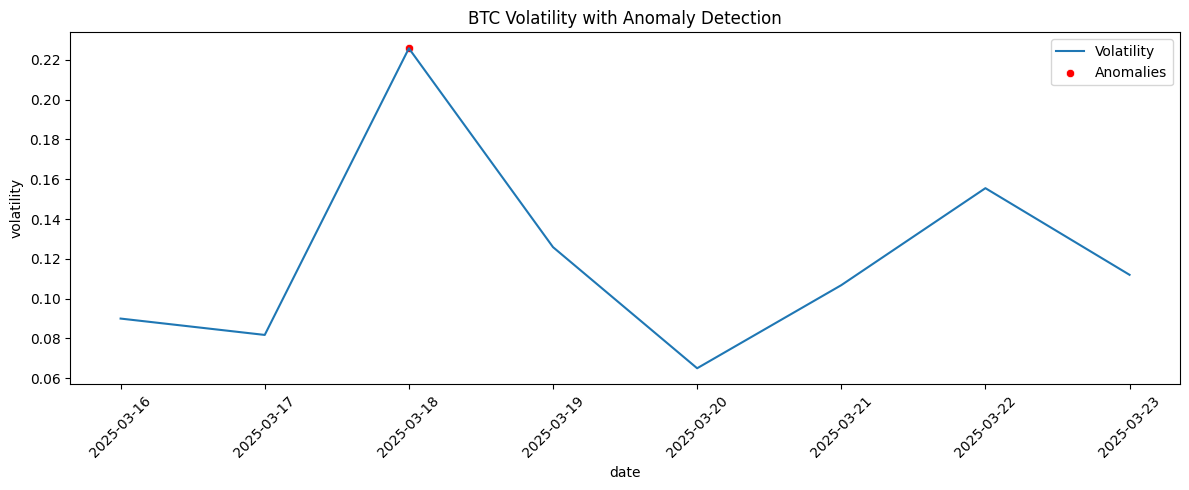

In [4]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_btc, x='date', y='volatility', label='Volatility')
sns.scatterplot(data=df_btc[df_btc['anomaly']], x='date', y='volatility', color='red', label='Anomalies')
plt.title("BTC Volatility with Anomaly Detection")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import zipfile

# Load the exported forecast results
forecast_df = pd.read_csv("forecast_results.csv")

# Extract rows marked as anomalies
labeled_anomalies = forecast_df[forecast_df["Anomaly"] == 1]

# Save the anomalies to a CSV file
anomalies_path = "labeled_anomalies.csv"
labeled_anomalies.to_csv(anomalies_path, index=False)

anomalies_path

csv_path = "labeled_anomalies.csv"
zip_path = "labeled_anomalies.zip"
labeled_anomalies.to_csv(csv_path, index=False)
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(csv_path, arcname="labeled_anomalies.csv")

📊 Anomaly Detection Confusion Matrix:

Detected  0
Actual     
0         1


C:\Users\cojur\AppData\Local\Temp\ipykernel_18464\1214702733.py:40: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


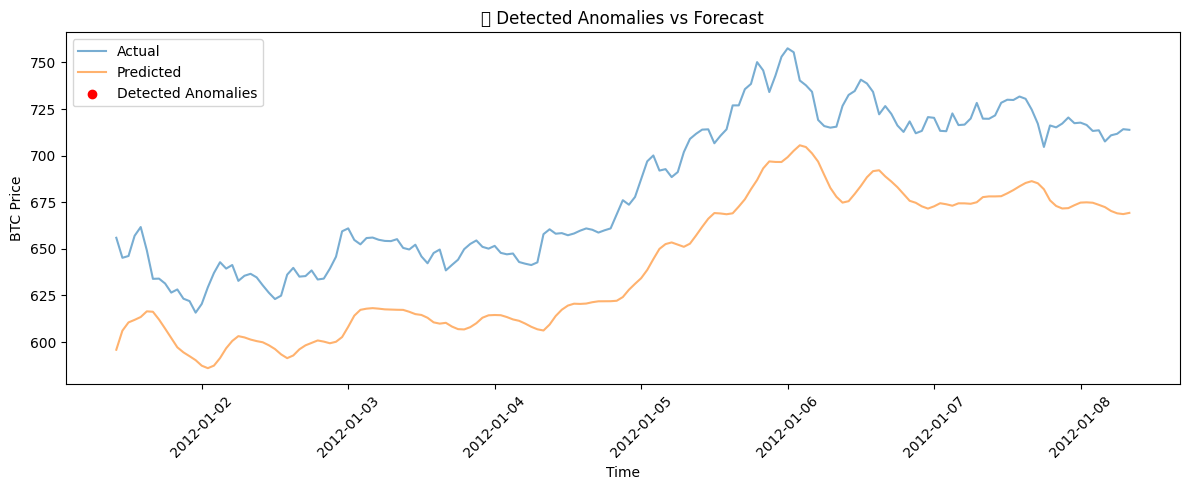

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
forecast_df = pd.read_csv("forecast_results.csv")
labeled = pd.read_csv("labeled_anomalies.csv")

# Generate timestamp column
start_time = pd.to_datetime("2012-01-01 10:00:00")  # adjust if needed
forecast_df["Timestamp"] = pd.date_range(start=start_time, periods=len(forecast_df), freq="h")
labeled["Timestamp"] = forecast_df["Timestamp"]

# Residuals and dynamic threshold
forecast_df["Residual"] = abs(forecast_df["Actual"] - forecast_df["Predicted"])
threshold = forecast_df["Residual"].mean() + 3 * forecast_df["Residual"].std()
forecast_df["Anomaly_Detected"] = (forecast_df["Residual"] > threshold).astype(int)

# Merge with labeled
merged = forecast_df.merge(labeled[["Timestamp", "Anomaly"]], on="Timestamp", suffixes=('', '_Labeled'))

# Show overlap
comparison = pd.crosstab(merged["Anomaly"], merged["Anomaly_Detected"],
                         rownames=["Actual"], colnames=["Detected"])

print("📊 Anomaly Detection Confusion Matrix:\n")
print(comparison)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(forecast_df["Timestamp"], forecast_df["Actual"], label="Actual", alpha=0.6)
plt.plot(forecast_df["Timestamp"], forecast_df["Predicted"], label="Predicted", alpha=0.6)
plt.scatter(forecast_df[forecast_df["Anomaly_Detected"] == 1]["Timestamp"],
            forecast_df[forecast_df["Anomaly_Detected"] == 1]["Actual"],
            color='red', label="Detected Anomalies")
plt.legend()
plt.title("🔍 Detected Anomalies vs Forecast")
plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd

# Load both datasets
forecast_df = pd.read_csv("forecast_results.csv")
labeled = pd.read_csv("labeled_anomalies.csv")

# Generate timestamp column
start_time = pd.to_datetime("2012-01-01 10:00:00")
forecast_df["Timestamp"] = pd.date_range(start=start_time, periods=len(forecast_df), freq="h")
labeled["Timestamp"] = forecast_df["Timestamp"]

# Calculate residuals and detection
forecast_df["Residual"] = abs(forecast_df["Actual"] - forecast_df["Predicted"])
threshold = forecast_df["Residual"].mean() + 3 * forecast_df["Residual"].std()
forecast_df["Anomaly_Detected"] = (forecast_df["Residual"] > threshold).astype(int)

# Merge with labeled data
merged = forecast_df.merge(labeled[["Timestamp", "Anomaly"]], on="Timestamp", suffixes=('', '_Labeled'))

# Save merged evaluation
merged.to_csv("anomaly_evaluation.csv", index=False)
"anomaly_evaluation.csv"

csv_path = "anomaly_evaluation.csv"
zip_path = "anomaly_evaluation.zip"
merged.to_csv(csv_path, index=False)
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(csv_path, arcname="anomaly_evaluation.csv")

In [15]:
import pandas as pd
import numpy as np

# Load the previous combined forecast + anomaly DataFrame
forecast_df = pd.read_csv("forecast_results.csv")

# Create synthetic true anomaly labels for demonstration
np.random.seed(42)
synthetic_labels = np.zeros(len(forecast_df), dtype=int)

# Randomly select a few indices as true anomalies
true_anomaly_indices = np.random.choice(forecast_df.index, size=int(0.05 * len(forecast_df)), replace=False)
synthetic_labels[true_anomaly_indices] = 1

# Add synthetic true labels to the DataFrame
forecast_df["True_Anomaly"] = synthetic_labels

# Save the modified DataFrame
forecast_df.to_csv("anomaly_eval_with_labels.csv", index=False)
forecast_df.head()

,Actual,Predicted,Residual,Anomaly,True_Anomaly
0,655.945500,595.871323,60.074177,0,0
1,645.200333,606.112350,39.087984,1,0
2,646.171500,610.536238,35.635262,2,0
3,657.004167,611.907031,45.097136,3,0
4,661.707500,613.435577,48.271923,4,0
